# 12.1 상태공간 모델 시작

데이터 분석을 위한 베이지안 통계 모델링 with Stan & R

In [1]:
library(tidyverse)
library(stringr)
library(rstan)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.1
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: StanHeaders

rstan (Version 2.21.2, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


Attaching package: ‘rstan’


The following object is masked from ‘package:tidyr’:

    extract




In [2]:
tbl <- read_csv("data/data-ss1.txt")
tbl

Parsed with column specification:
cols(
  X = col_double(),
  Y = col_double()
)



X,Y
<dbl>,<dbl>
1,11.2
2,11.0
3,11.3
4,10.8
5,10.8
6,11.3
7,11.1
8,11.0
9,11.4


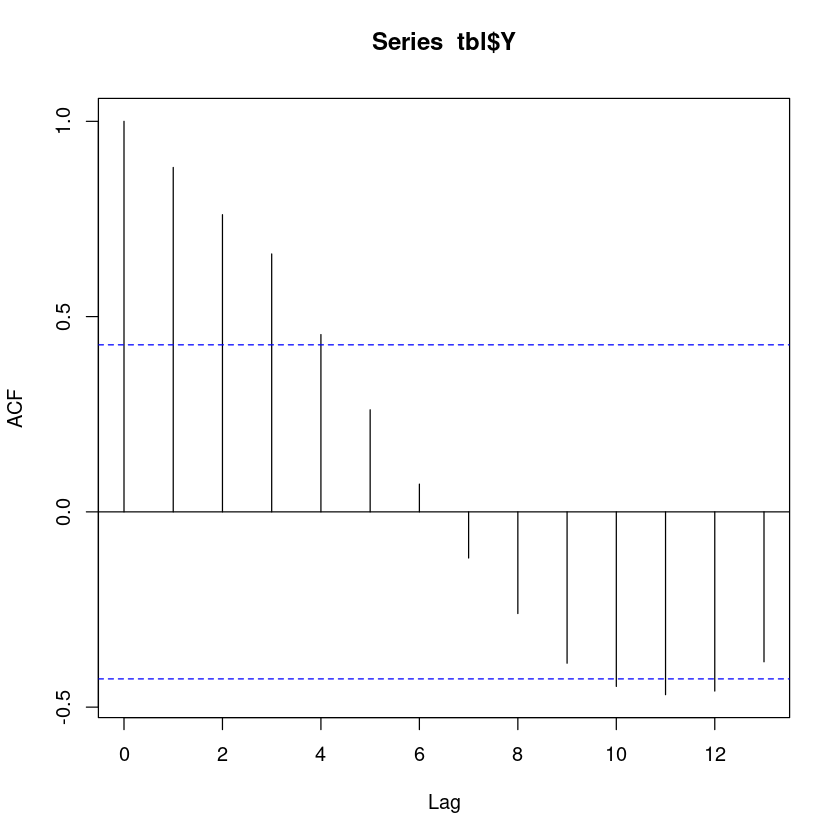

In [3]:
acf(tbl$Y)

In [4]:
stan_code = "
data {
  int T;
  int T_pred;
  vector[T] Y;
}

parameters {
  vector[T] mu;
  real<lower=0> s_mu;
  real<lower=0> s_Y;
}

model {
  mu[2:T] ~ normal(mu[1:(T - 1)], s_mu);
  Y ~ normal(mu, s_Y);
}

generated quantities {
  vector[T + T_pred] mu_all;
  vector[T_pred] y_pred;
  mu_all[1:T] = mu;
  for (t in 1:T_pred) {
    mu_all[T + t] = normal_rng(mu_all[T + t - 1], s_mu);
    y_pred[t] = normal_rng(mu_all[T + t], s_Y);
  }
}
"

fit <- stan(model_code = stan_code,
            data = list(T = 21, T_pred = 5, Y = tbl$Y),
            verbose = FALSE)
fit_ss <- rstan::extract(fit)


SAMPLING FOR MODEL 'ed32c38526f8029062fb03dac6a6d659' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 1e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.077598 seconds (Warm-up)
Chain 1:                0.067778 seconds (Sampling)
Cha

Warning message:
“There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#tail-ess”


In [5]:
tbl_ci <- fit_ss$mu_all
tbl_ci <- as_tibble(tbl_ci) %>%
  map(function(x) quantile(x, c(0.1, 0.25, 0.5, 0.75, 0.9))) %>%
  as_tibble() %>%
  mutate(q = c("10%", "25%", "50%", "75%", "90%")) %>%
  pivot_longer(cols = -q) %>%
  mutate(x = str_sub(name, start = 2L),
         x = as.double(x))
tbl_ci[1:5,]

Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if `.name_repair` is omitted as of tibble 2.0.0.
Using compatibility `.name_repair`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


q,name,value,x
<chr>,<chr>,<dbl>,<dbl>
10%,V1,10.99652,1
10%,V2,10.88970,2
10%,V3,11.01720,3
10%,V4,10.70071,4
10%,V5,10.70675,5


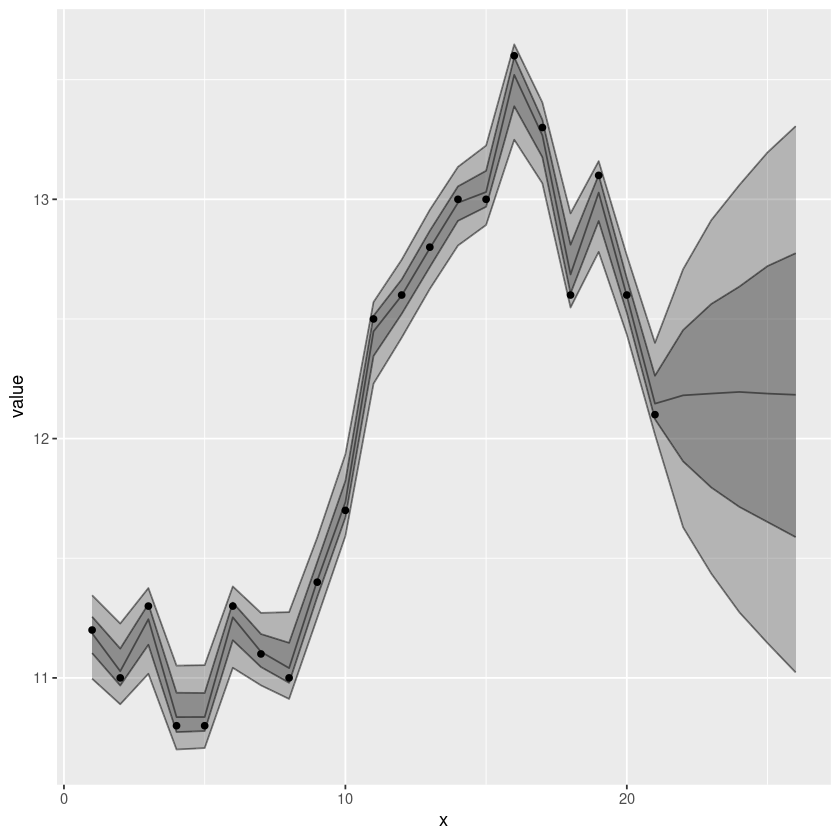

In [6]:
ggplot() +
geom_ribbon(data = tbl_ci %>% pivot_wider(names_from = q, values_from = value),
            aes(x = x, ymin = `10%`, ymax = `90%`), alpha = 0.3) +
geom_ribbon(data = tbl_ci %>% pivot_wider(names_from = q, values_from = value),
            aes(x = x, ymin = `25%`, ymax = `75%`), alpha = 0.3) +
geom_line(data = tbl_ci, aes(x = x, y = value, group = q), alpha = 0.5) +
geom_point(data = tbl, aes(x = X, y = Y))